## Test fiducial cosmologies in fits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace_manager.data import data_MPGADGET
from lace_manager.likelihood import likelihood
from lace_manager.likelihood import full_theory
from lace_manager.likelihood import CAMB_model
from lace_manager.sampler import emcee_sampler
import time

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu_type="polyfit"
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.22 seconds


### Set full theory, with a given fiducial model

In [6]:
# true cosmology used in mock data
cosmo_sim=data.mock_sim.sim_cosmo
camb_cosmo.print_info(cosmo_sim)
theory_sim=full_theory.FullTheory(zs=data.z,emulator=emu,theta_MC=False,cosmo_fid=cosmo_sim)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


In [7]:
# setup fiducial cosmo
cosmo_fid=camb_cosmo.get_cosmology(omch2=0.13)
camb_cosmo.print_info(cosmo_fid) 
theory_fid=full_theory.FullTheory(zs=data.z,emulator=emu,theta_MC=False,cosmo_fid=cosmo_fid)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.3000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


### Set likelihood, sampler, and run analysis

In [8]:
def run_analysis(theory,emulator=None,cosmo_fid_label='default',
                 prior=0.5,n_burn_in=30,n_steps=300,delta_lnprob_cut=50):
    # set free parameters
    free_param_limits=[[1.1e-09, 3.19e-09],[0.89, 1.05],[-0.2, 0.2]]
    free_param_names=["As","ns","ln_tau_0"]
    # set likelihood
    like=likelihood.Likelihood(data=data,theory=theory,emulator=emulator,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,
                            cosmo_fid_label=cosmo_fid_label,
                            include_CMB=False)
    # set sampler
    sampler = emcee_sampler.EmceeSampler(like=like,
                        verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)
    for p in sampler.like.free_params:
        print(p.name,p.value,p.min_value,p.max_value)
    # run sampler
    start = time.time()
    sampler.run_sampler(n_burn_in,n_steps,parallel=False)
    end = time.time()
    sampler_time = end - start
    print("Sampling took {0:.1f} seconds".format(sampler_time))
    
    # print best-fit and truth
    best_fit_cube=sampler.get_best_fit(delta_lnprob_cut=delta_lnprob_cut)
    best_fit_params=sampler.like.parameters_from_sampling_point(best_fit_cube)
    for par in best_fit_params:
        name=par.name
        latex_name=emcee_sampler.param_dict[name]
        best_fit=par.value
        if latex_name in sampler.truth:
            truth=sampler.truth[latex_name]
        else:
            truth=0.0
        print(par.info_str(),truth)
        
    return sampler

In [9]:
# parameters to use in corner plots
plot_params=['$A_s$','$n_s$','$\Delta^2_\star$','$n_\star$']

### Use simulation cosmo as fiducial

In [10]:
sampler_sim=run_analysis(theory_sim)

As 2.006055e-09 1.1e-09 3.19e-09
ns 0.967565 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


100%|█████████████████████████████████████████| 330/330 [01:17<00:00,  4.28it/s]

Sampling took 77.3 seconds
will keep 2970 \ 3000 points from chain
As = 2.0182100826292475e-09 2.006055e-09
ns = 0.9657343791369817 0.967565
ln_tau_0 = 0.001336112838096204 0.0


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:380: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 2970 \ 3000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:814: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


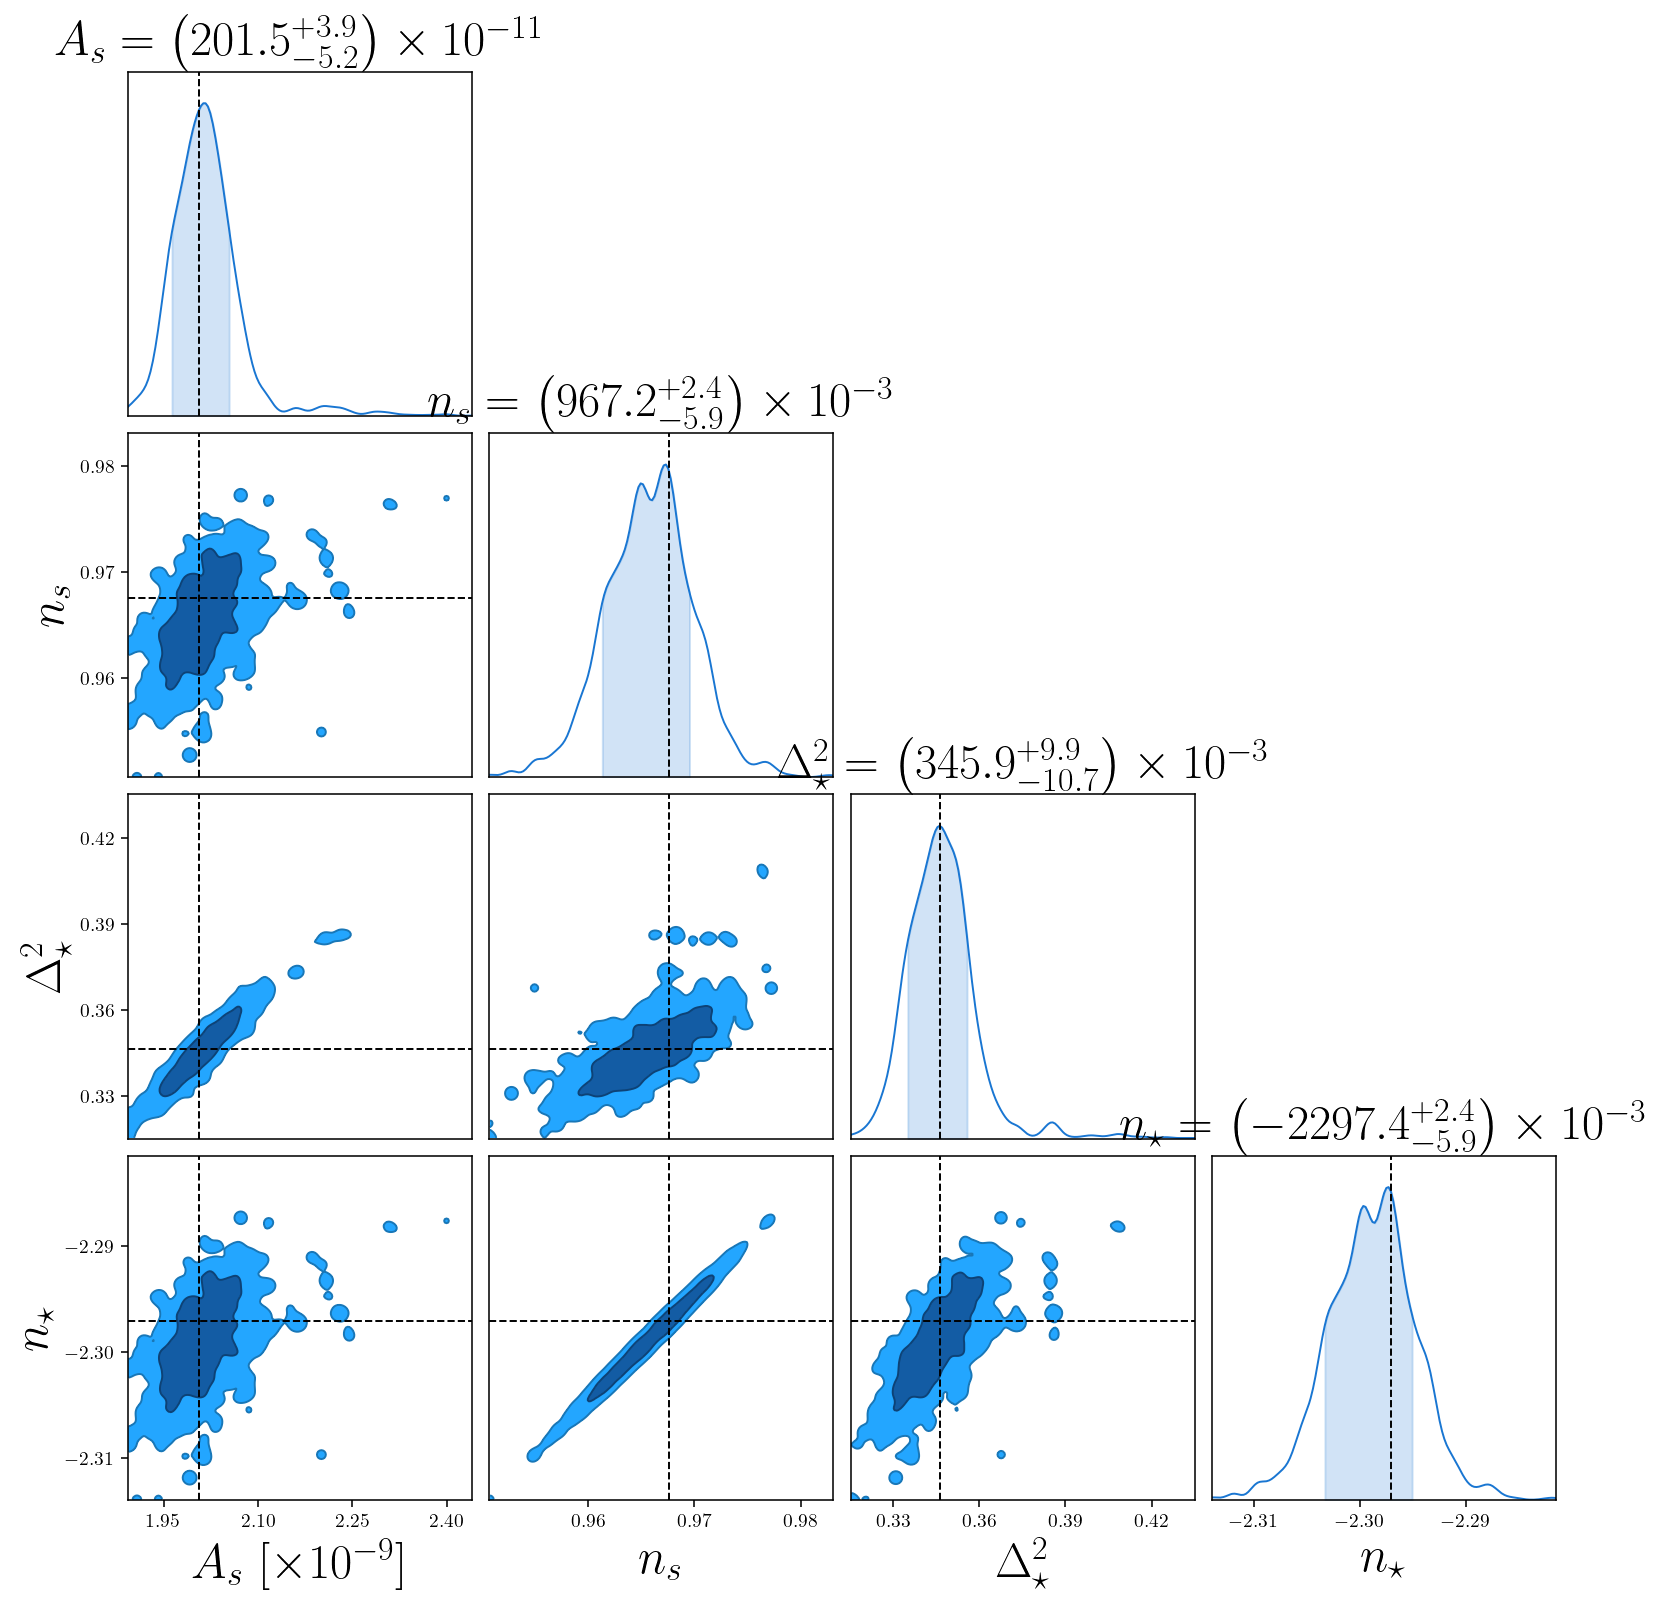

In [11]:
sampler_sim.plot_corner(cmb_prior=False,delta_lnprob_cut=50,plot_params=plot_params)

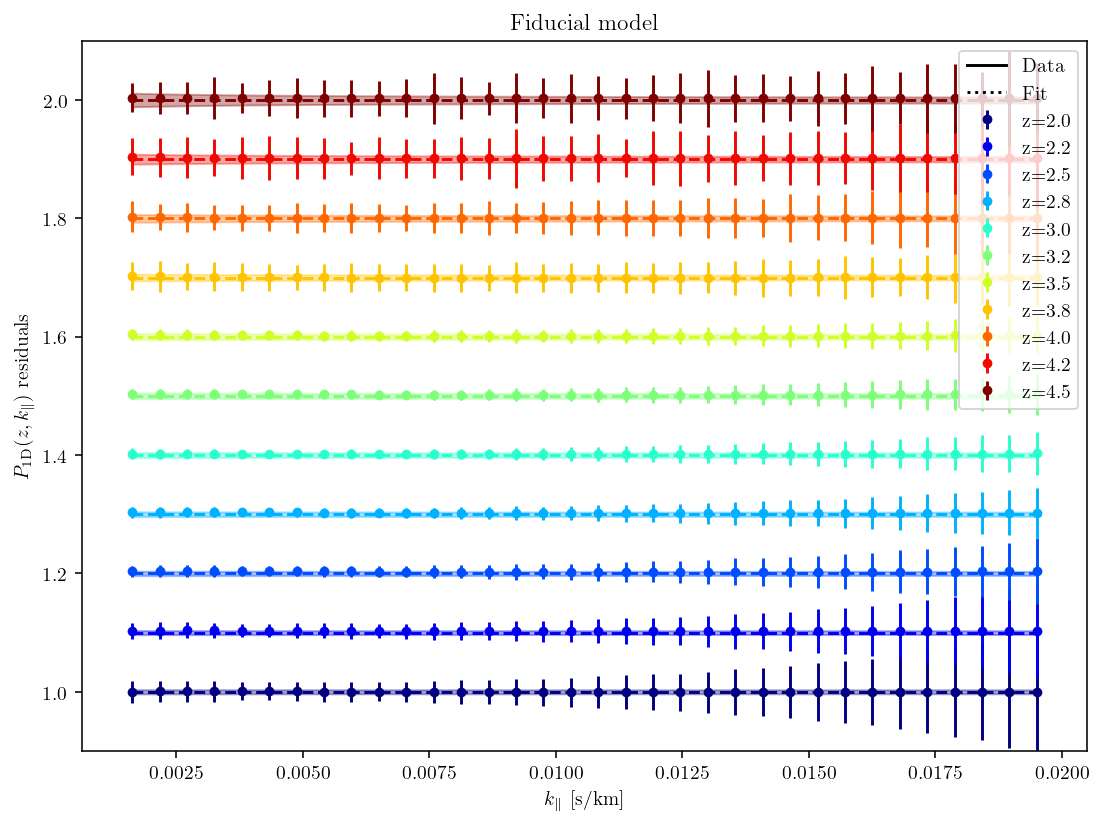

In [12]:
sampler_sim.plot_prediction(residuals=True)

will keep 2970 \ 3000 points from chain
Mean values: [0.43933496776519015, 0.47333986960613544, 0.5033402820952405]


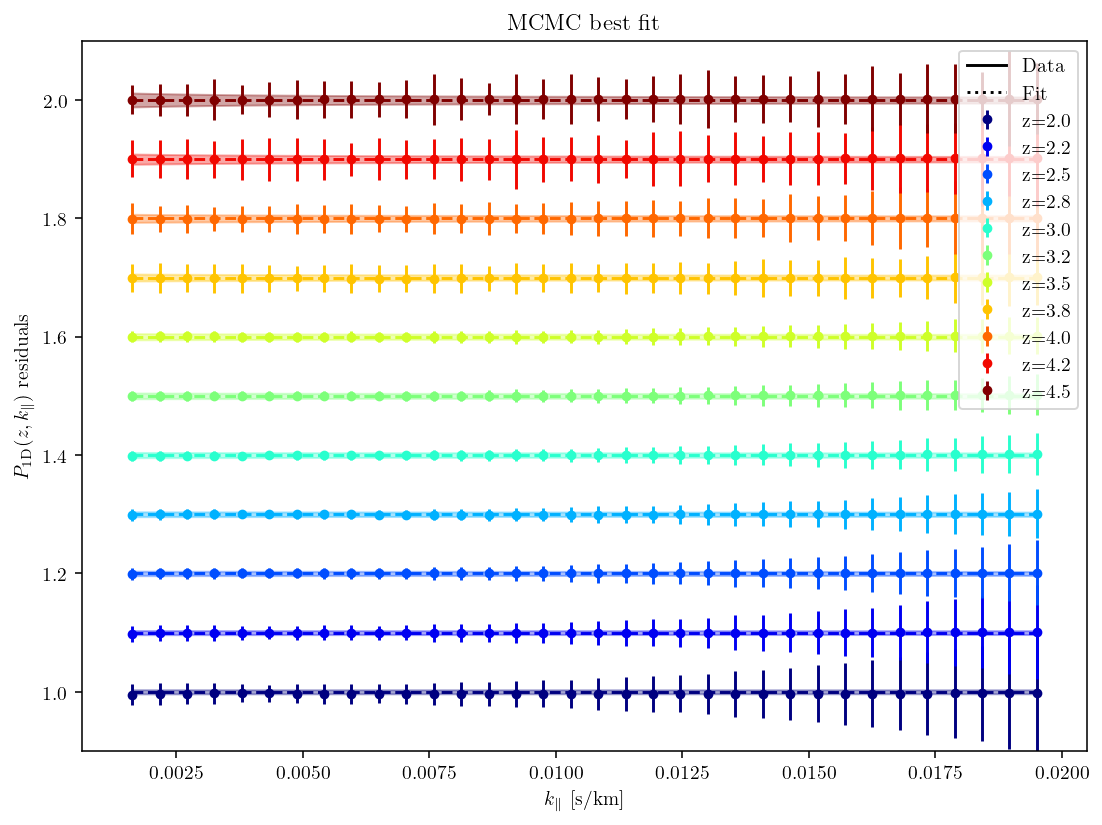

In [13]:
sampler_sim.plot_best_fit(residuals=True,delta_lnprob_cut=50)

### Use wrong fiducial

In [14]:
sampler_fid=run_analysis(theory_fid)

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


100%|█████████████████████████████████████████| 330/330 [02:19<00:00,  2.36it/s]

Sampling took 140.2 seconds
will keep 2989 \ 3000 points from chain
As = 1.787064950629938e-09 2.006055e-09
ns = 0.9534147728097964 0.967565
ln_tau_0 = -0.00093509319166038 0.0


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:380: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 2989 \ 3000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:814: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


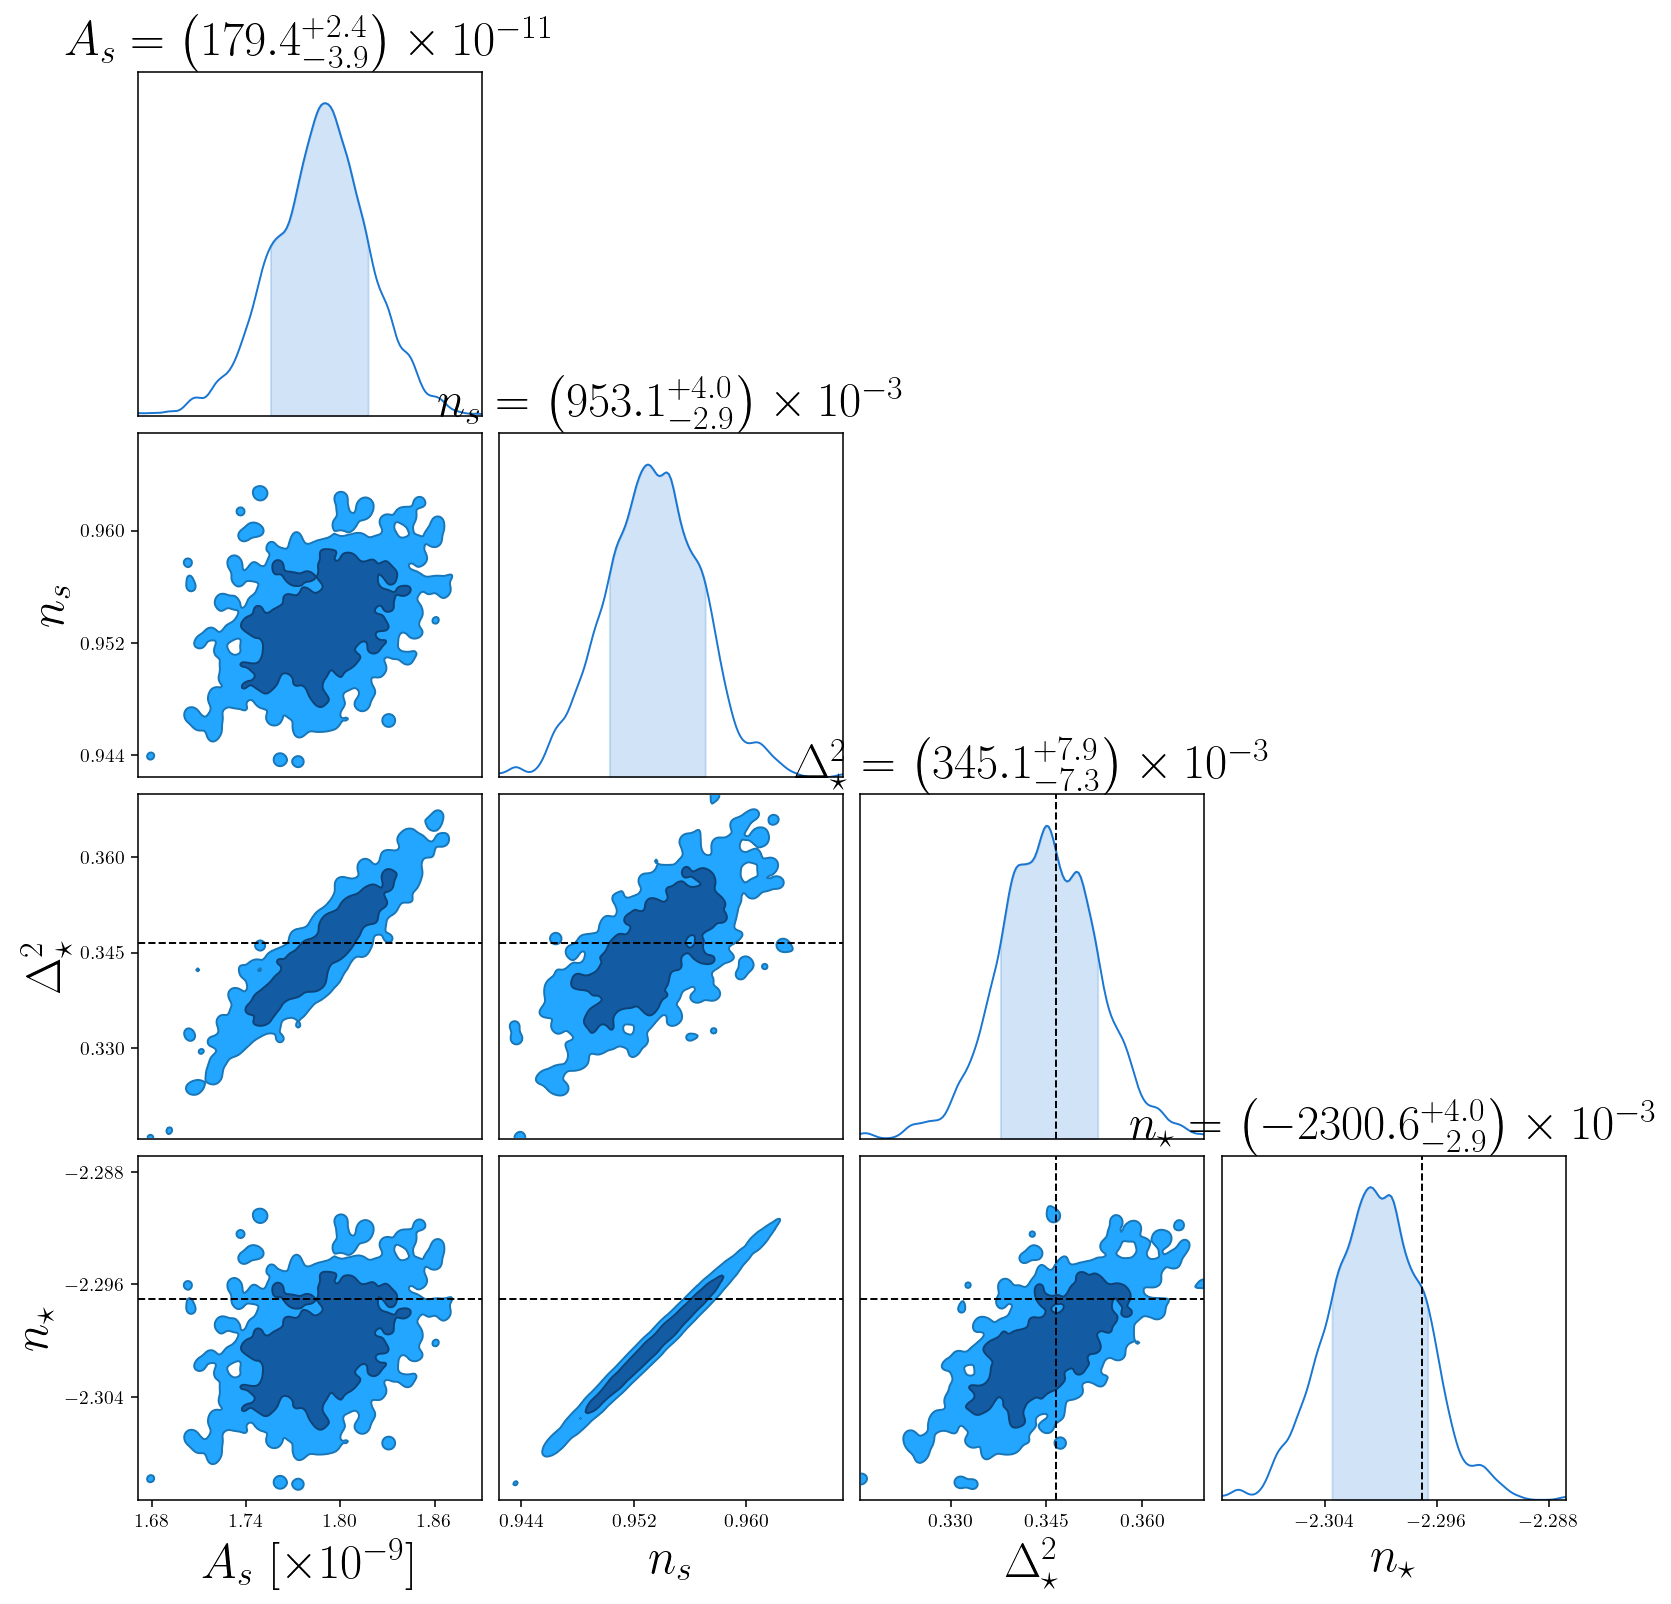

In [15]:
sampler_fid.plot_corner(cmb_prior=False,delta_lnprob_cut=50,plot_params=plot_params)

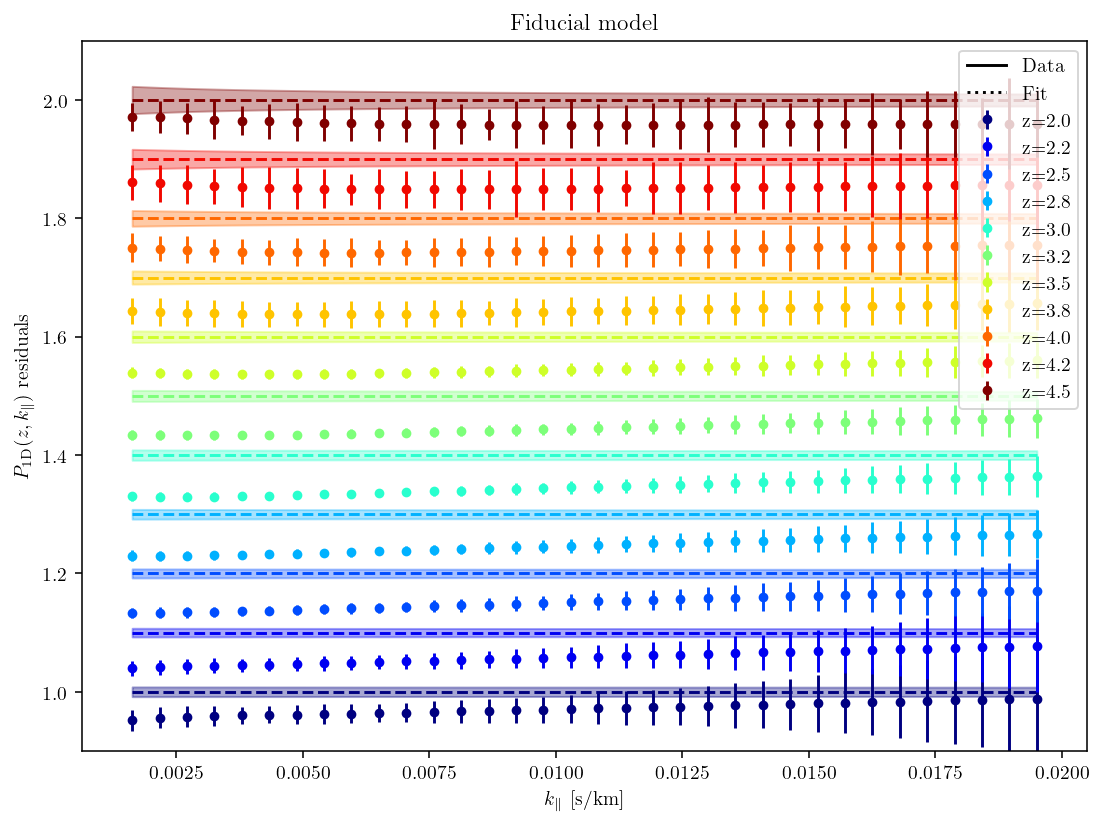

In [16]:
sampler_fid.plot_prediction(residuals=True)

will keep 2989 \ 3000 points from chain
Mean values: [0.32873921082772145, 0.39634233006122704, 0.49766226702084904]


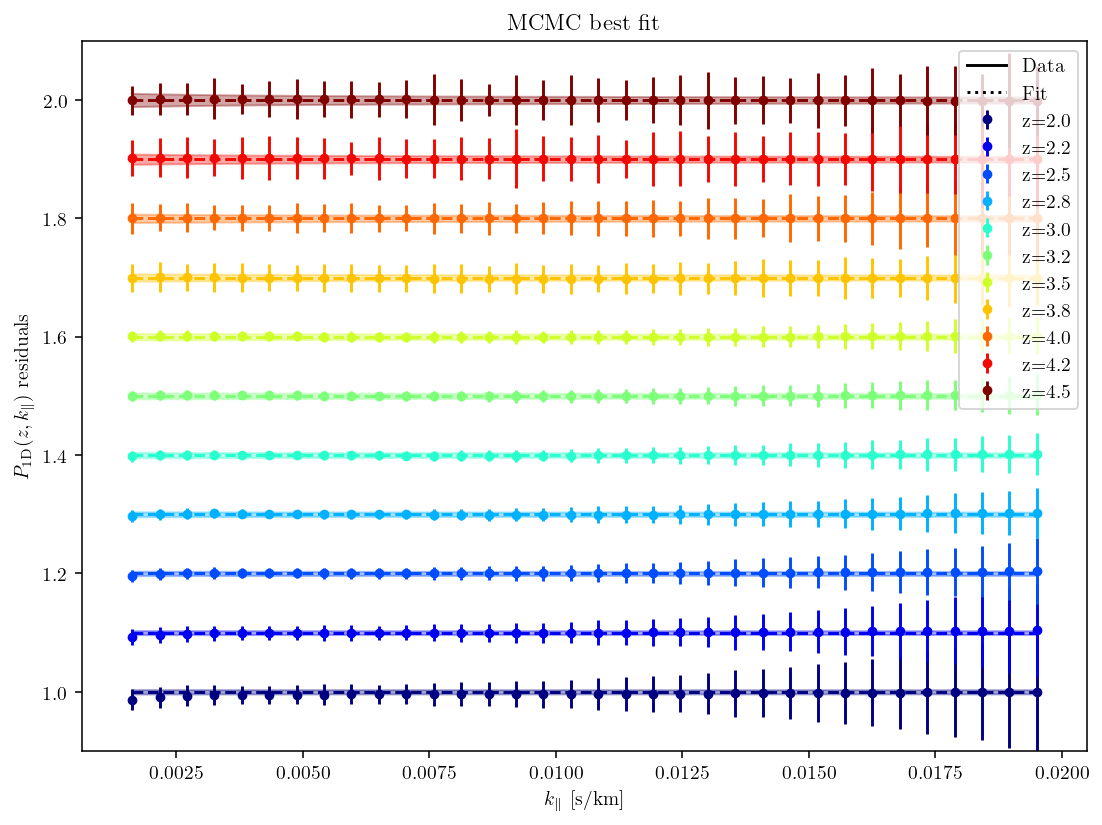

In [17]:
sampler_fid.plot_best_fit(residuals=True,delta_lnprob_cut=50)

### Use default fiducial, via likelihood

In [18]:
sampler_emu=run_analysis(theory=None,emulator=emu,cosmo_fid_label='default')

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


100%|█████████████████████████████████████████| 330/330 [02:48<00:00,  1.96it/s]

Sampling took 168.8 seconds
will keep 2992 \ 3000 points from chain
As = 2.0179384100183943e-09 2.006055e-09
ns = 0.9658536514568308 0.967565
ln_tau_0 = 0.0013188389372890685 0.0


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:380: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 2992 \ 3000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:814: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


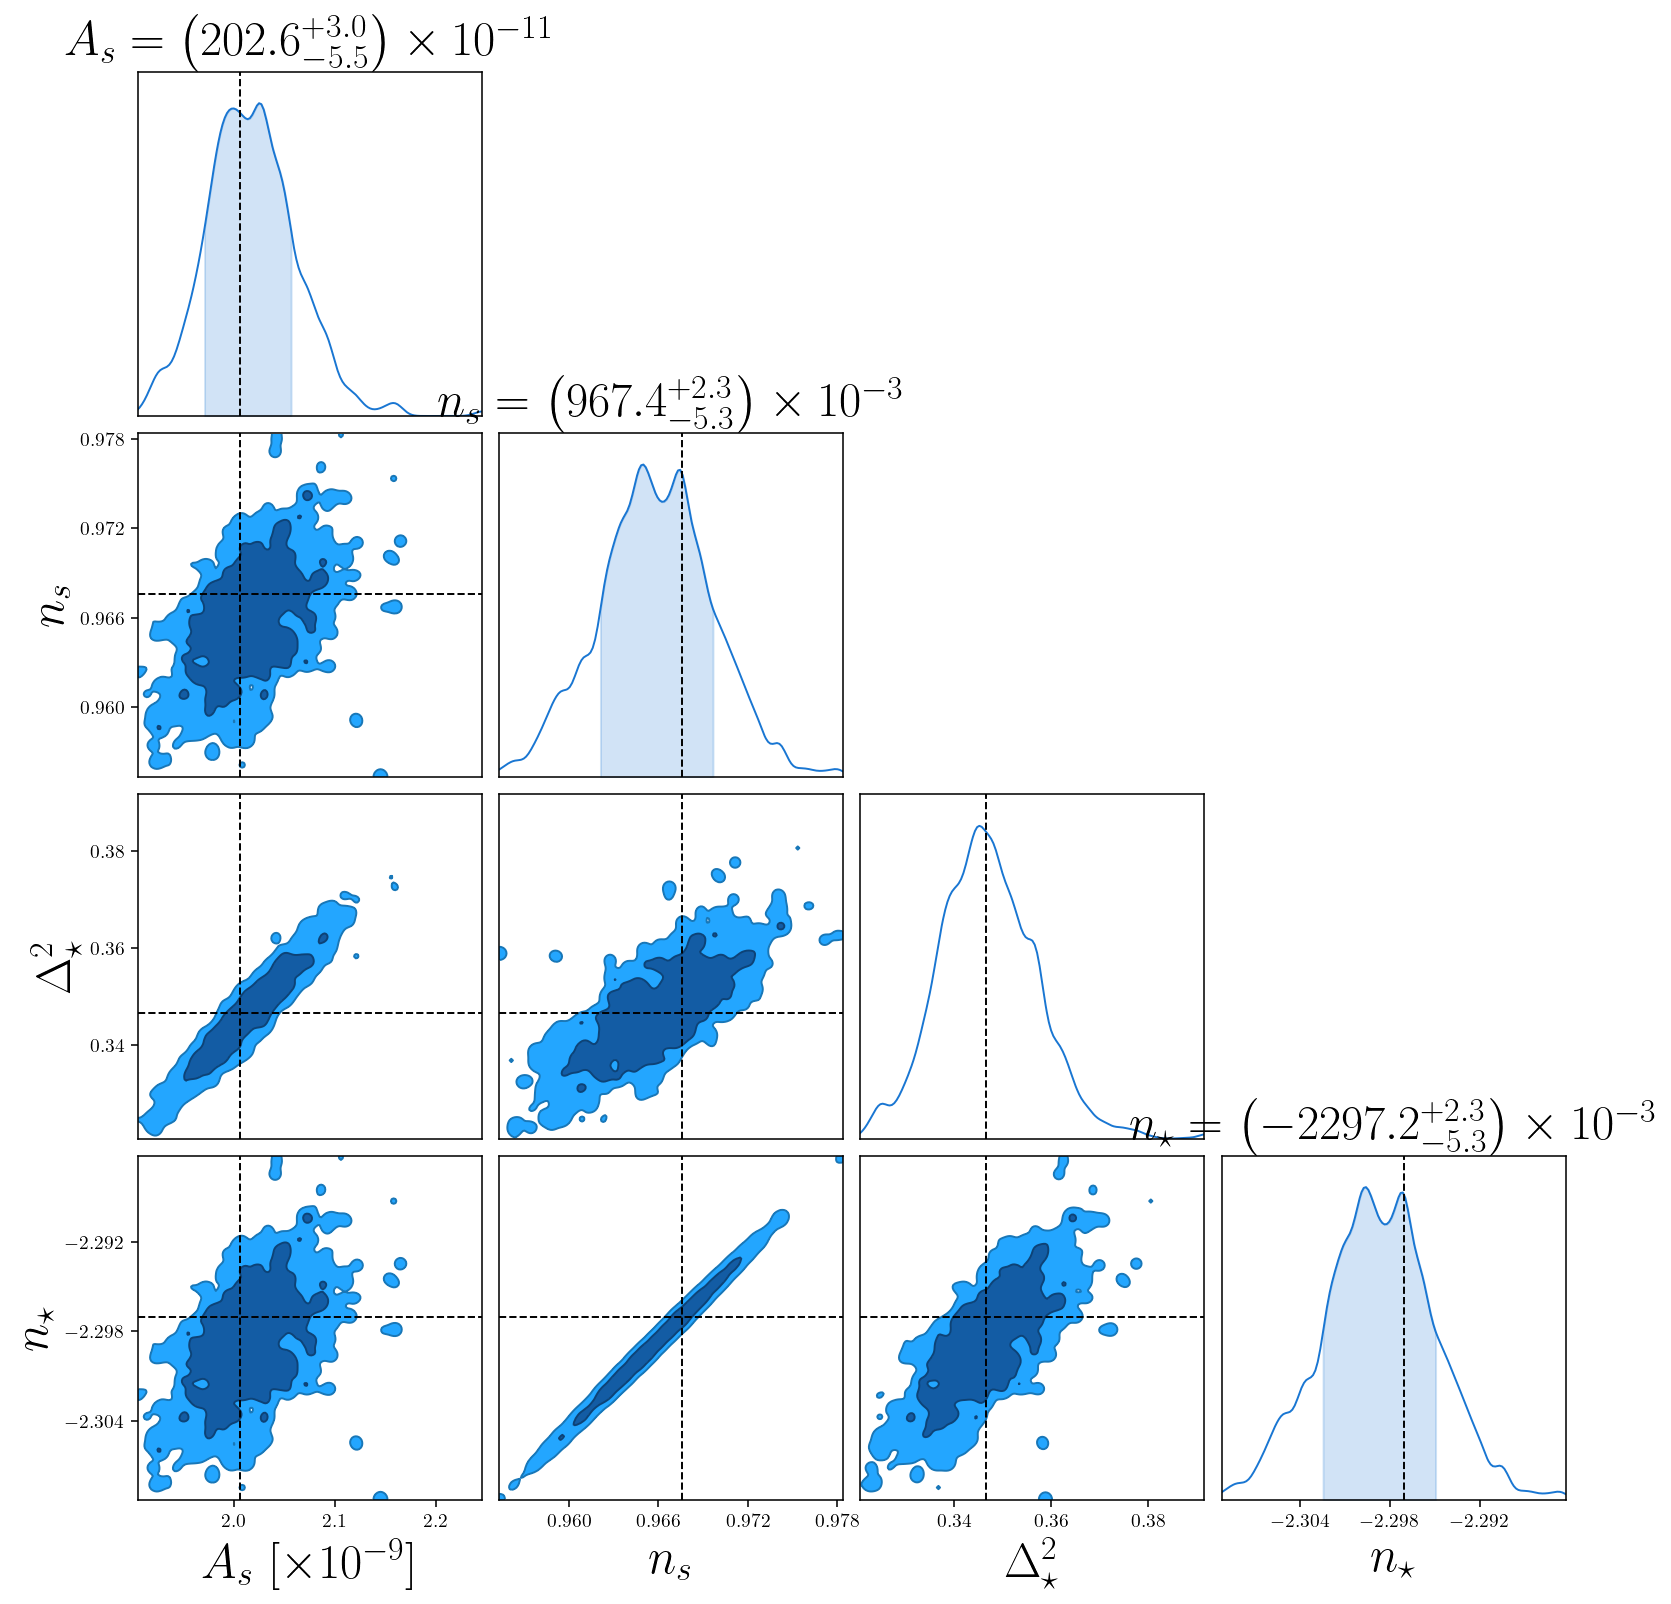

In [19]:
sampler_emu.plot_corner(cmb_prior=False,delta_lnprob_cut=50,plot_params=plot_params)

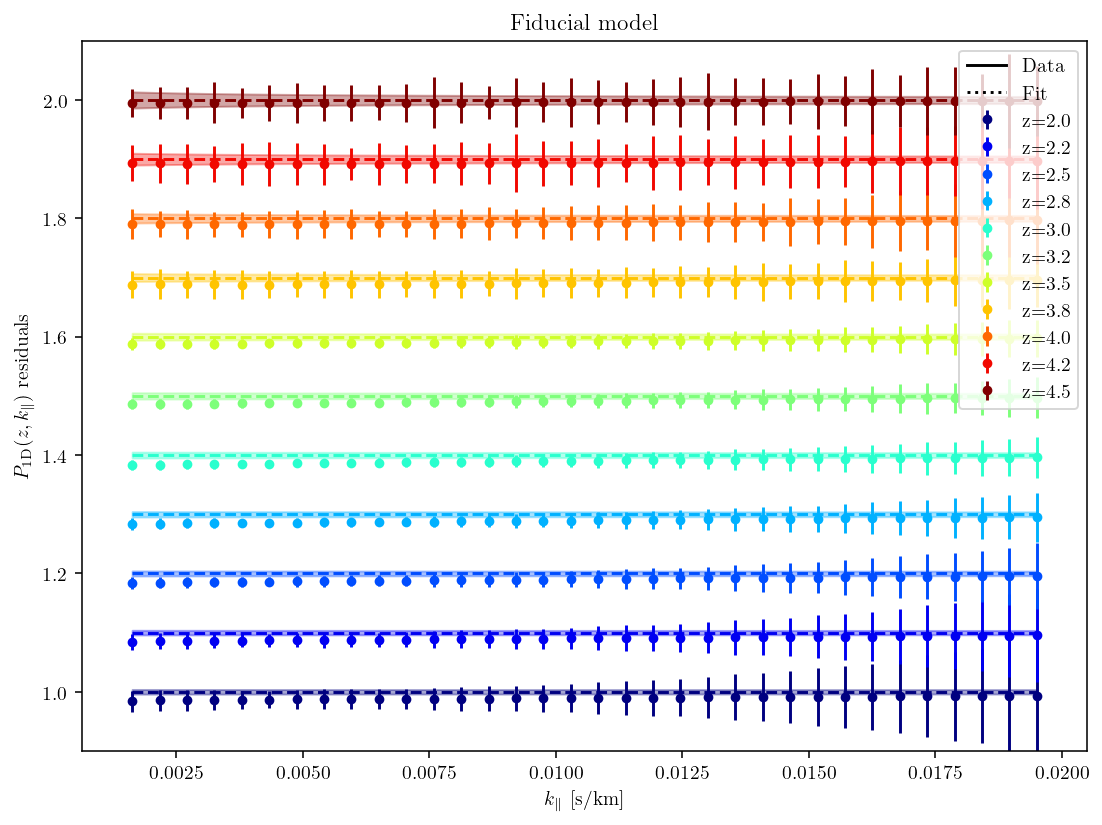

In [20]:
sampler_emu.plot_prediction(residuals=True)

will keep 2992 \ 3000 points from chain
Mean values: [0.43920498087004506, 0.4740853216051918, 0.5032970973432227]


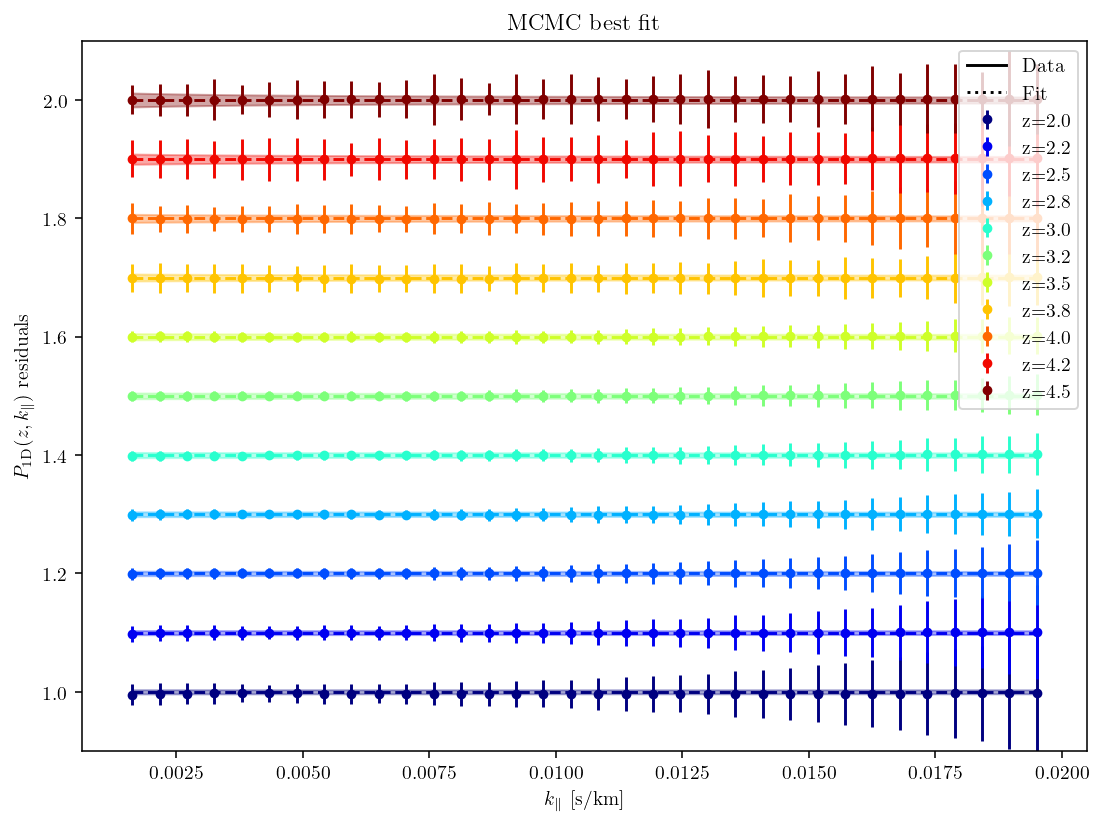

In [21]:
sampler_emu.plot_best_fit(residuals=True,delta_lnprob_cut=50)

### Use simulation cosmo as fiducial, via likelihood

In [22]:
sampler_use=run_analysis(theory=None,emulator=emu,cosmo_fid_label='truth')

As 2.006055e-09 1.1e-09 3.19e-09
ns 0.967565 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


100%|█████████████████████████████████████████| 330/330 [02:40<00:00,  2.06it/s]

Sampling took 160.8 seconds
will keep 2691 \ 3000 points from chain
As = 2.019643103010678e-09 2.006055e-09
ns = 0.965956984468592 0.967565
ln_tau_0 = 0.0008154064661220206 0.0


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:380: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 2691 \ 3000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:814: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


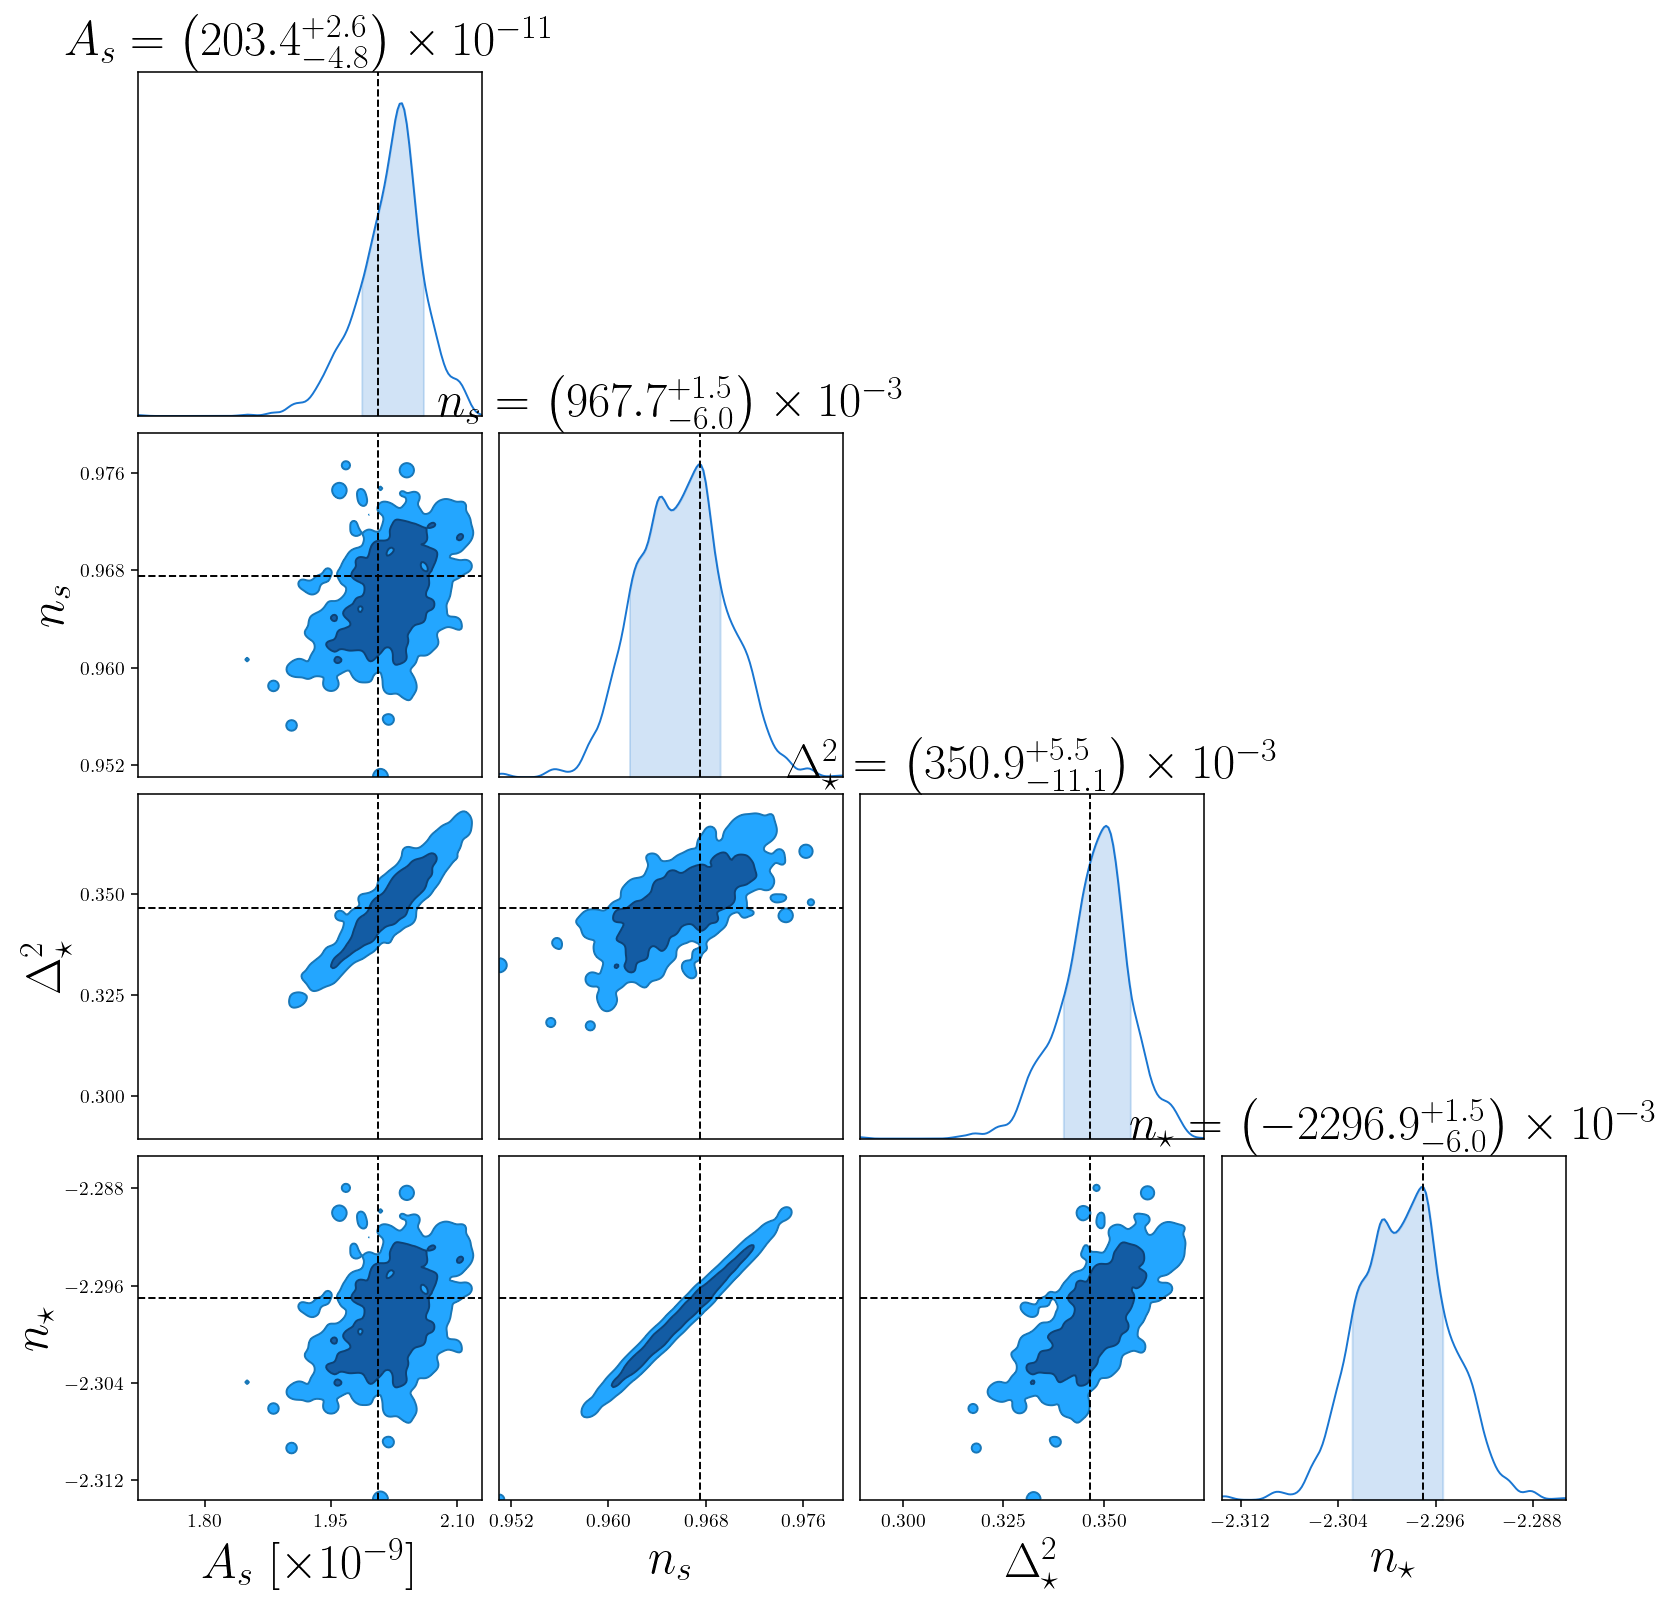

In [23]:
sampler_use.plot_corner(cmb_prior=False,delta_lnprob_cut=50,plot_params=plot_params)

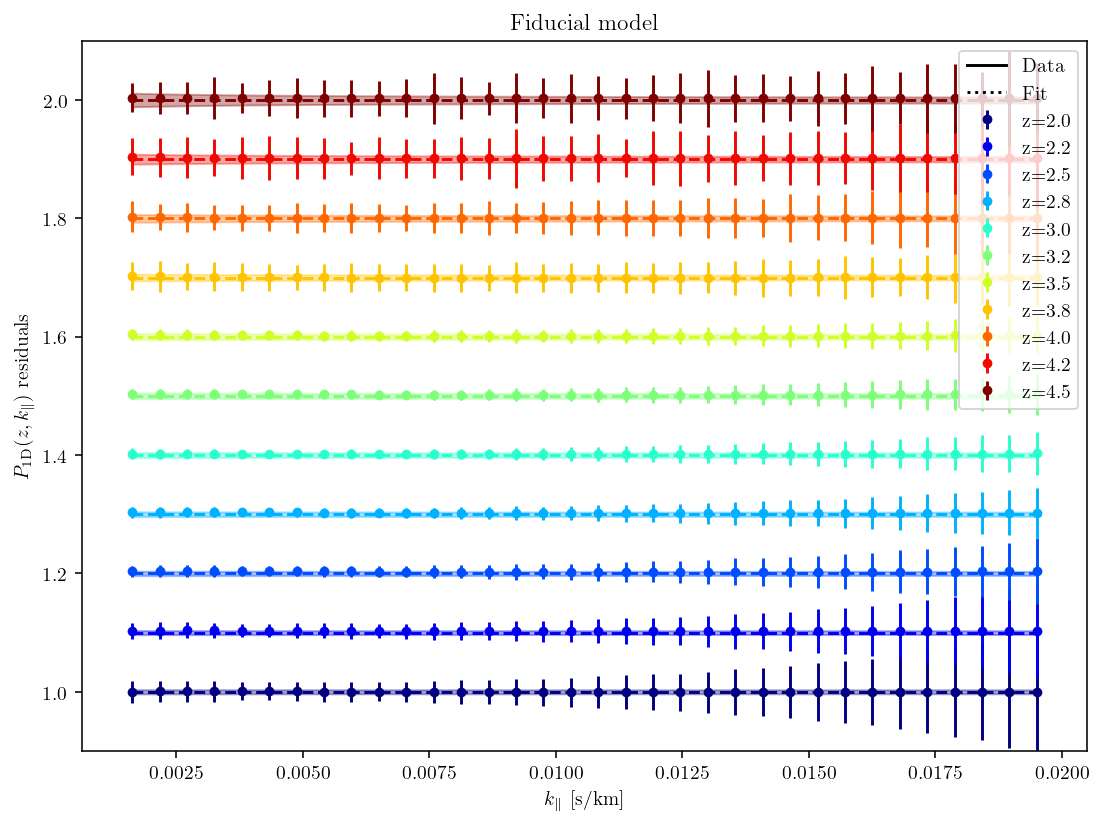

In [24]:
sampler_use.plot_prediction(residuals=True)

will keep 2691 \ 3000 points from chain
Mean values: [0.4400206234500852, 0.47473115292870016, 0.502038516165305]


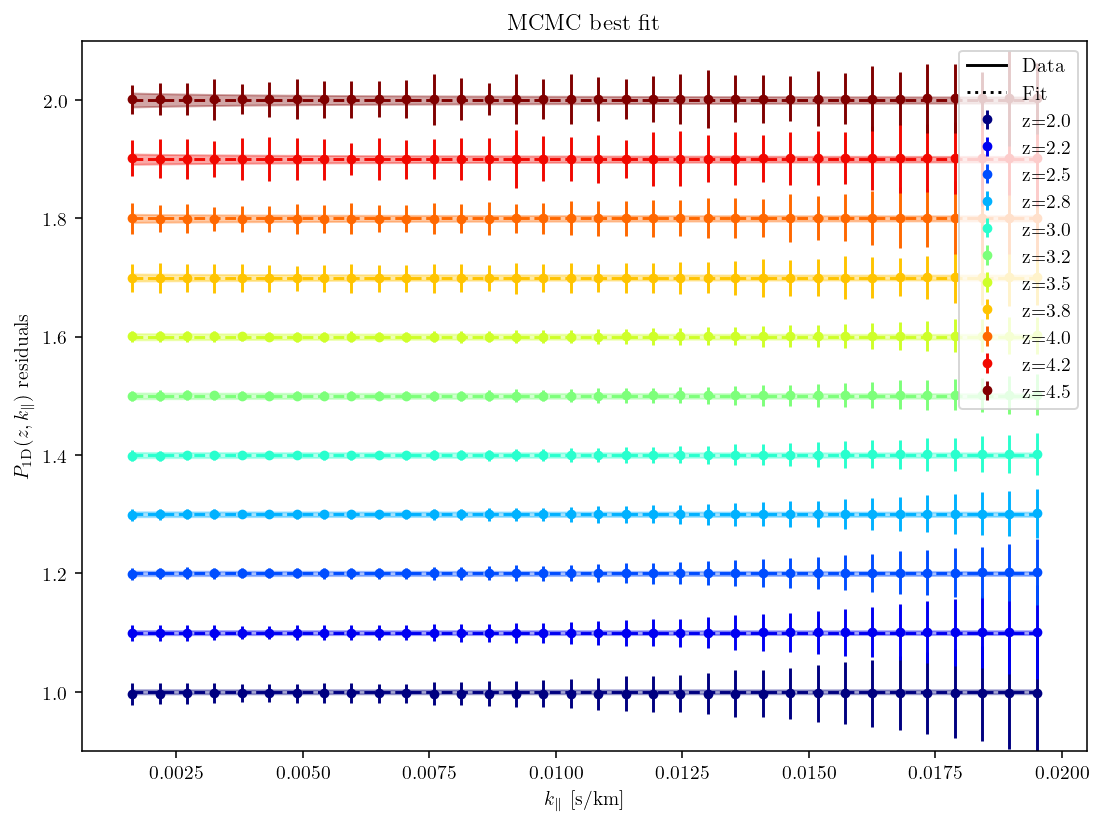

In [25]:
sampler_use.plot_best_fit(residuals=True,delta_lnprob_cut=50)

### Use wrong fiducial, via likelihood

In [26]:
sampler_bad=run_analysis(theory=None,emulator=emu,cosmo_fid_label='low_omch2')

specified fiducial cosmology
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.1000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


100%|█████████████████████████████████████████| 330/330 [02:17<00:00,  2.40it/s]

Sampling took 138.2 seconds
will keep 2998 \ 3000 points from chain
As = 2.284991213742098e-09 2.006055e-09
ns = 0.9761563796802395 0.967565
ln_tau_0 = 0.00592301641647075 0.0


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:380: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 2998 \ 3000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:814: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


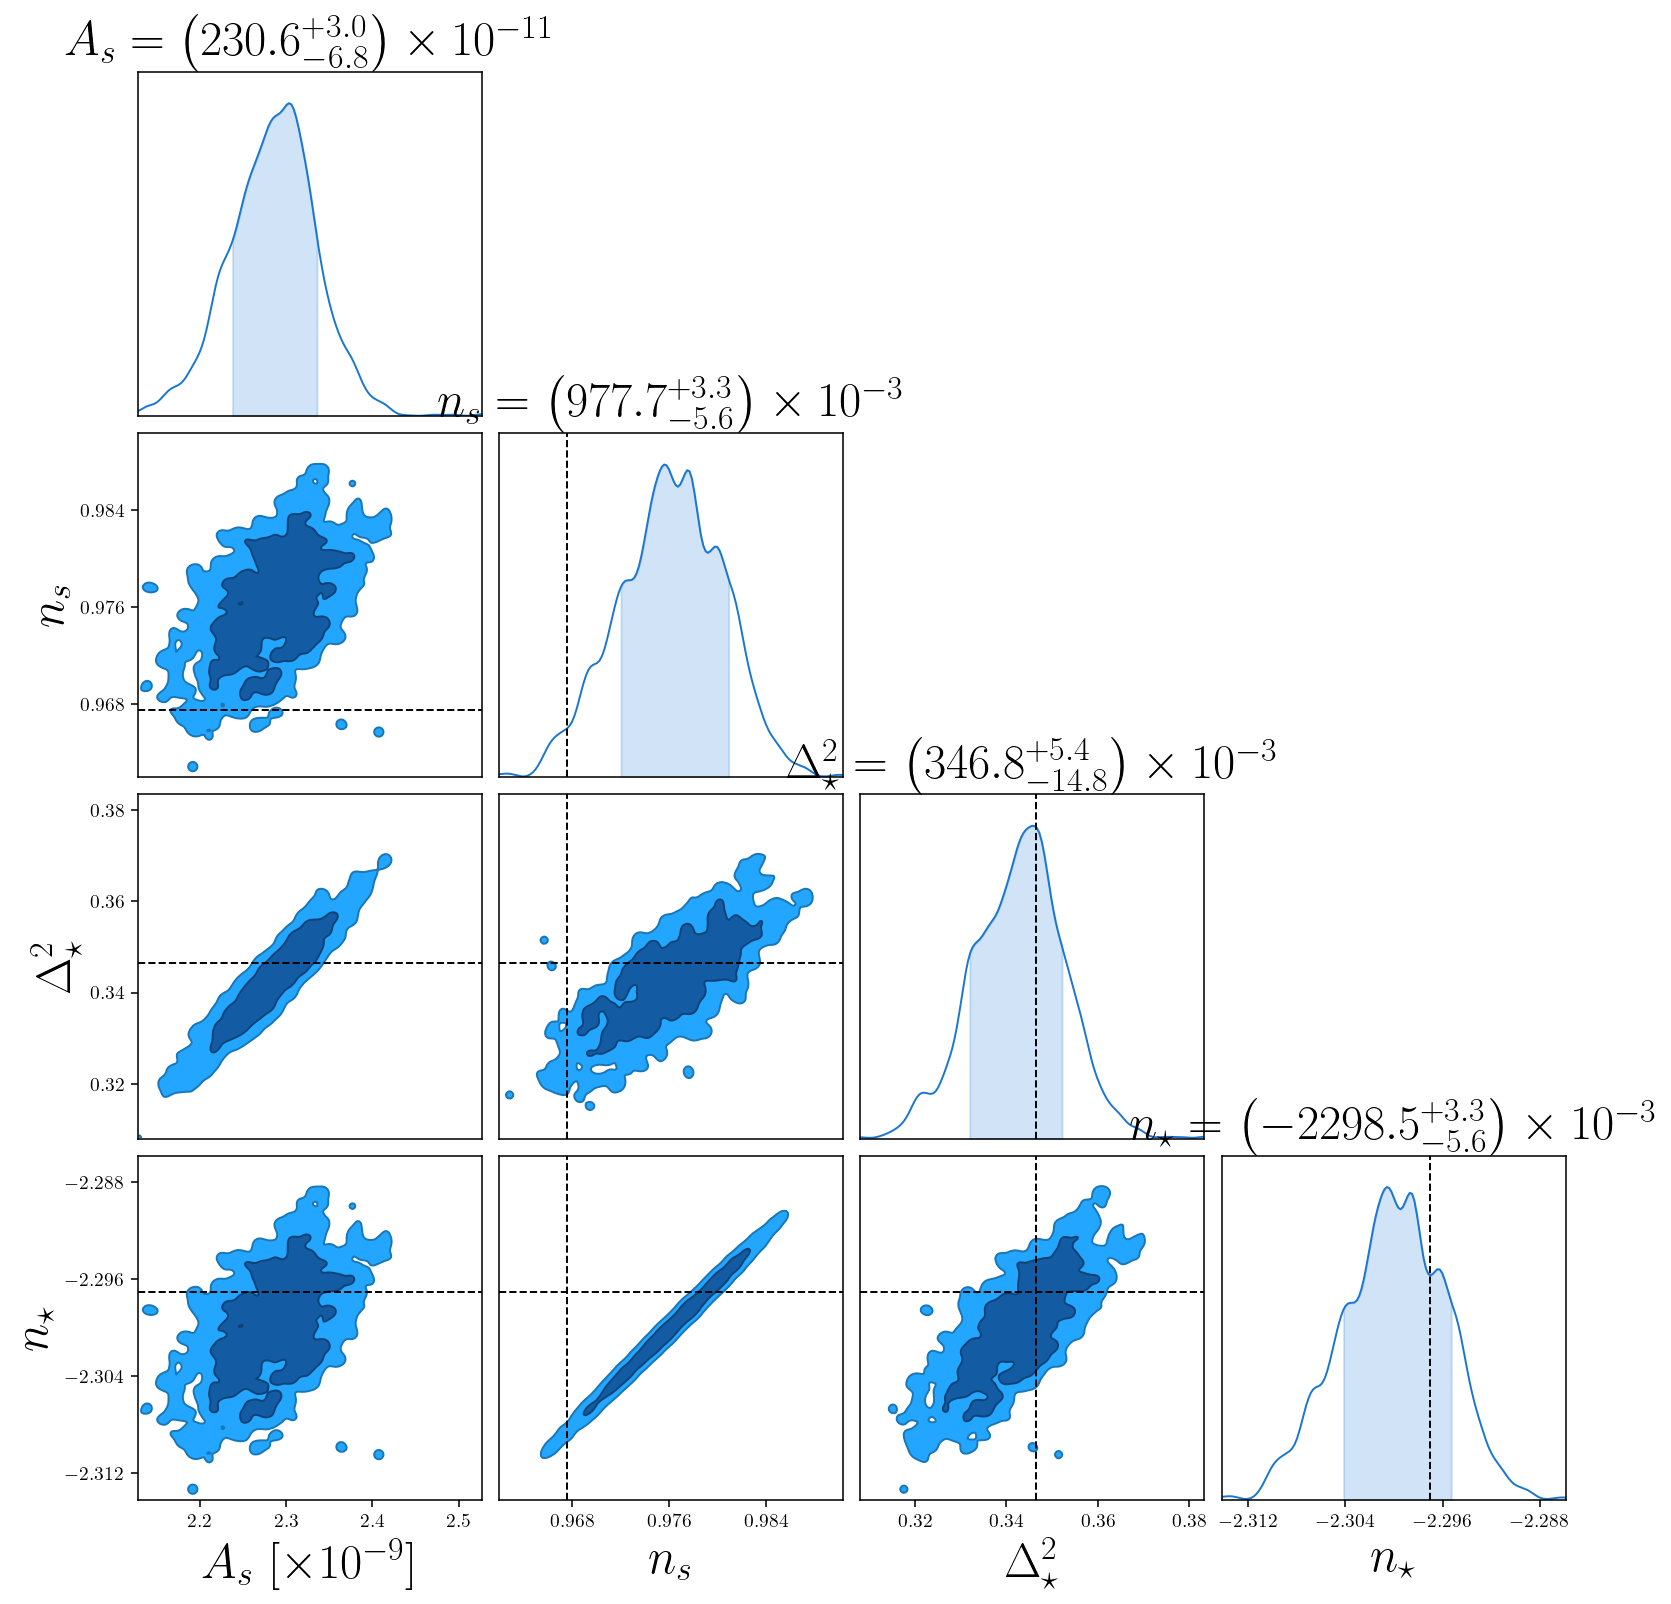

In [27]:
sampler_bad.plot_corner(cmb_prior=False,delta_lnprob_cut=50,plot_params=plot_params)

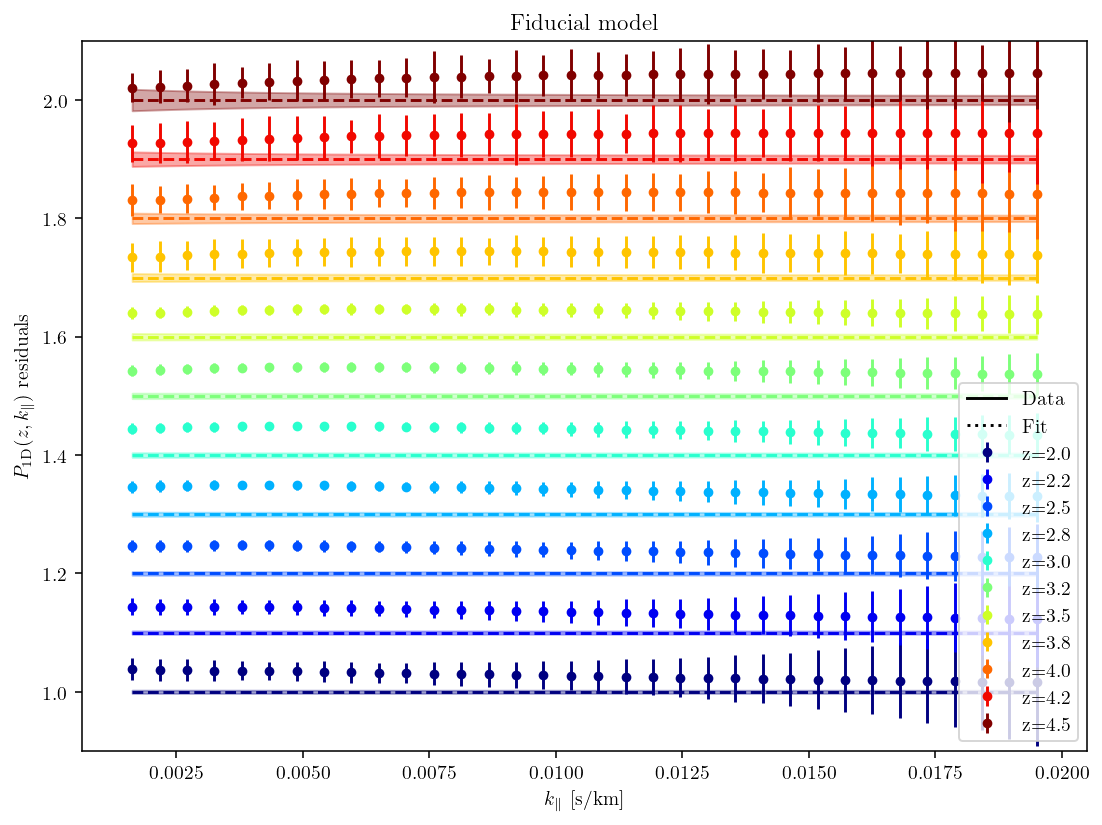

In [28]:
sampler_bad.plot_prediction(residuals=True)

will keep 2998 \ 3000 points from chain
Mean values: [0.5669814419818652, 0.5384773730014966, 0.5148075410411769]


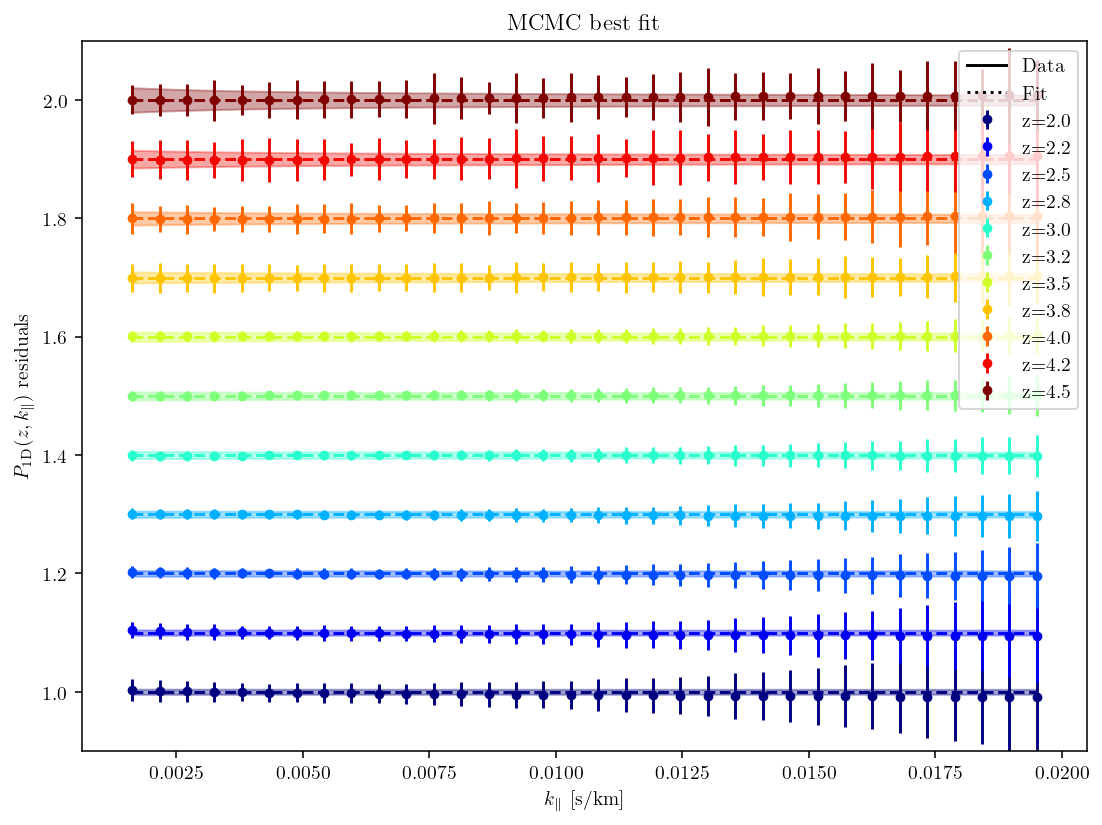

In [29]:
sampler_bad.plot_best_fit(residuals=True,delta_lnprob_cut=50)